# **News: Gemini (Google)**

Website: https://deepmind.google/technologies/gemini/

Blogpost: https://blog.google/technology/ai/google-gemini-ai

Mutlimodality video: https://twitter.com/GoogleDeepMind/status/1732461149554094259

Paper: https://paperswithcode.com/paper/gemini-a-family-of-highly-capable-multimodal

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('jV1vkHv4zq8')

# **Keras 3.0**

Most important features:
- multi-backend (Tensorflow, JAX, Pytorch)
- Keras Ops module
- optimized & redesigned
- KerasCV & KerasNLP packages

## **Instalation**

From command line:
```bash
pip3 install keras --upgrade
```

For Anaconda environment:
```bash
conda activate Yourenvironment
conda install pytorch
pip3 install keras --upgrade
```
   
When making a new env:
```bash
conda create -n Keras3 python=3.11 pytorch #(or tensorflow or jax)
conda activate Keras3
pip3 install keras --upgrade
```

For Conda installation, GPU support should set-up automatially. If you encounter issues, checkout the current requirements at https://github.com/keras-team/keras/tree/master.

## **Import & select backend**

From Python script or notebook:
```python
import os
os.environ["KERAS_BACKEND"] = "jax"
```

From command line:
```bash
export KERAS_BACKEND="jax"
```

Permanently:

edit file `keras.json` (usually it's located in `.keras` hidden folder in your home directory)
```json
{
    ...
    "backend": "jax",
    ...
}
```

In [16]:
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "torch"

from keras import ops
from keras import layers
from keras.models import Model, Sequential
from keras.metrics import CategoricalAccuracy
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
from keras.datasets import mnist

## **Load data**

In [17]:
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Normalize 
X_train = X_train / 255
X_val = X_val / 255  

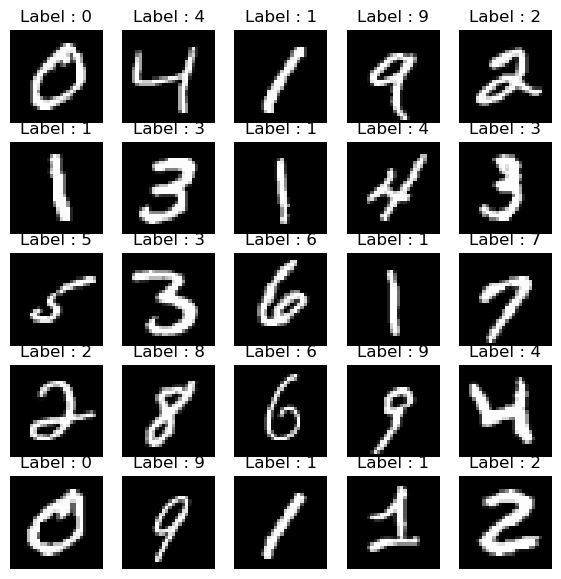

In [18]:
plt.figure(figsize=(7,7))
x = 1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,x)
        plt.title(f"Label : {y_train[x]}")
        plt.imshow(X_train[x], cmap="gray");
        plt.axis("off")
        x += 1

### **Transform X**

In [19]:
X_train.shape

(60000, 28, 28)

In [20]:
# Reshape
X_train = X_train.reshape((*X_train.shape, 1))  
X_val = X_val.reshape((*X_val.shape, 1))

In [21]:
X_train.shape

(60000, 28, 28, 1)

### **Transform Y**

In [22]:
y_train[0]

5

In [23]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [24]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [25]:
ops.argmax(y_train[0])

tensor(5, device='cuda:0', dtype=torch.int32)

## **Define network**

In [26]:
def get_model():
    model = Sequential(
        [layers.Input(shape=(28, 28, 1)),
         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
         layers.GlobalAveragePooling2D(),
         layers.Dropout(0.2),
         layers.Dense(10, activation="softmax")]
    )
    
    return model

model = get_model()

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 64)        │        640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_2      │ (None, 64)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,218 (149.29 KB)

 Trainable params: 38,218 (149.29 KB)

 Non-trainable params: 0 (0.00 B)

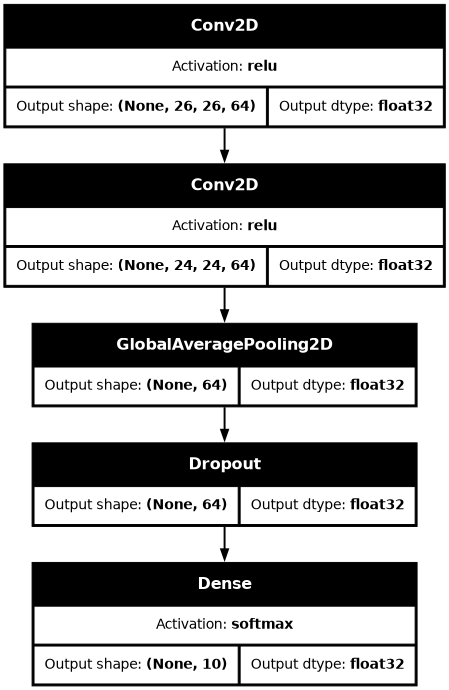

In [28]:
plot_model(
    model,
    dpi=70,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    rankdir="TB"
)

## **Train model**

### **Default `.fit` method**

In [29]:
model = get_model()

model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=64, epochs=10)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.2834 - loss: 1.8991 - val_categorical_accuracy: 0.6230 - val_loss: 1.1944
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.5314 - loss: 1.2981 - val_categorical_accuracy: 0.7449 - val_loss: 0.9152
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.6313 - loss: 1.0624 - val_categorical_accuracy: 0.8241 - val_loss: 0.6901
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7091 - loss: 0.8705 - val_categorical_accuracy: 0.8490 - val_loss: 0.5722
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7505 - loss: 0.7465 - val_categorical_accuracy: 0.8734 - val_loss: 0.4797
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7823 - loss: 0.6629 - val_categorical_accuracy: 0.8962 - val_loss: 0.3900
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.8070 - los

### **Custom fit**

In [30]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### **optimizer \& loss function**

In [31]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()

def loss_fn(y_true, y_pred):
    # Clipping - keeps the sum of y_pred at 1
    y_pred = ops.clip(y_pred, 1e-7, 1 - 1e-7)
    
    loss = -(y_true * ops.log(y_pred) + (1 - y_true) * ops.log(1 - y_pred))
    return ops.mean(loss)

#### **1. input array (batchsize $\,\times\,$ image shape)**

In [32]:
batchsize = 16

inputs = torch.tensor(X_train[0:batchsize], device=device)
targets = torch.tensor(y_train[0:batchsize], device=device)

print(inputs.shape, targets.shape)

torch.Size([16, 28, 28, 1]) torch.Size([16, 10])


In [33]:
print(inputs.device, targets.device)

cuda:0 cuda:0


#### **2. forward pass - array of probabilities (batchsize $\,\times\,$ classes)**

In [34]:
probs = model(inputs)

probs.shape

torch.Size([16, 10])

In [35]:
probs[0]

tensor([0.1009, 0.0997, 0.0990, 0.1013, 0.1009, 0.0981, 0.1006, 0.0984, 0.1013,
        0.0998], device='cuda:0', grad_fn=<SelectBackward0>)

In [36]:
probs[0].sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

#### **3. calculate the loss**

In [37]:
loss = loss_fn(probs, targets)

loss

tensor(2.8854, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)

#### **4. backward pass**

In [38]:
model.zero_grad()

loss.backward()

#### **5. optimizer**

In [39]:
optimizer.step()

#### **check if model changed**

In [40]:
probs2 = model(inputs)

loss2 = loss_fn(probs2, targets)

loss2

tensor(2.8697, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)

### **Training loop**

In [41]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()


batchsize = 128
epochs = 10
number_of_updates = X_train.shape[0] // batchsize

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    
    for step in range(number_of_updates):
        i0 = step * batchsize
        i1 = (step+1) * batchsize
        
        # Pytorch Tensor + Send to GPU
        inputs = torch.tensor(X_train[i0:i1], device=device)
        targets = torch.tensor(y_train[i0:i1], device=device)
        
        # Forward pass
        probs = model(inputs)
        loss = loss_fn(probs, targets)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        # Log every 100 batches.
        if i1 % 1000 == 0:
            print(f"Training loss at step {step:4d} ({(step + 1) * batchsize:5d} images): {loss.cpu().detach().numpy():.4f}")

Epoch: 1
Training loss at step  124 (16000 images): 2.0470
Training loss at step  249 (32000 images): 2.0459
Training loss at step  374 (48000 images): 2.0562
Epoch: 2
Training loss at step  124 (16000 images): 1.9513
Training loss at step  249 (32000 images): 1.9929
Training loss at step  374 (48000 images): 1.9634
Epoch: 3
Training loss at step  124 (16000 images): 1.8157
Training loss at step  249 (32000 images): 1.8704
Training loss at step  374 (48000 images): 1.8863
Epoch: 4
Training loss at step  124 (16000 images): 1.7817
Training loss at step  249 (32000 images): 1.8495
Training loss at step  374 (48000 images): 1.8505
Epoch: 5
Training loss at step  124 (16000 images): 1.7976
Training loss at step  249 (32000 images): 1.8466
Training loss at step  374 (48000 images): 1.8554
Epoch: 6
Training loss at step  124 (16000 images): 1.7868
Training loss at step  249 (32000 images): 1.8426
Training loss at step  374 (48000 images): 1.8442
Epoch: 7
Training loss at step  124 (16000 ima

### **Measure accuracy**

In [42]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()

# Metrcis: Categorical Accuracy
train_acc_metric = CategoricalAccuracy()
val_acc_metric = CategoricalAccuracy()


batchsize = 128
epochs = 10
number_of_updates = X_train.shape[0] // batchsize

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    
    for step in range(number_of_updates):
        i0 = step * batchsize
        i1 = (step+1) * batchsize
        
        # Pytorch Tensor + Send to GPU
        inputs = torch.tensor(X_train[i0:i1], device=device)
        targets = torch.tensor(y_train[i0:i1], device=device)
        
        # Forward pass
        probs = model(inputs)
        loss = loss_fn(probs, targets)

        # Update metrics
        train_acc_metric.update_state(targets, probs)
        
        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        # Log every 100 batches.
        if i1 % 1000 == 0:
            print(f"Training loss at step {step:4d} ({(step + 1) * batchsize:5d} images): {loss.cpu().detach().numpy():.4f}")
            
    train_acc = train_acc_metric.result()
    print(f"Training acc: {float(train_acc):.4f}")
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_state()

    # Calculate 
    val_probs = model(X_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_val, val_probs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_state()
    print(f"Validation acc: {float(val_acc):.4f}\n")

Epoch: 1
Training loss at step  124 (16000 images): 2.1763
Training loss at step  249 (32000 images): 2.1681
Training loss at step  374 (48000 images): 2.1050
Training acc: 0.2735
Validation acc: 0.3439

Epoch: 2
Training loss at step  124 (16000 images): 2.0942
Training loss at step  249 (32000 images): 2.0950
Training loss at step  374 (48000 images): 2.0575
Training acc: 0.3938
Validation acc: 0.4180

Epoch: 3
Training loss at step  124 (16000 images): 2.0281
Training loss at step  249 (32000 images): 2.0543
Training loss at step  374 (48000 images): 2.0256
Training acc: 0.4533
Validation acc: 0.4741

Epoch: 4
Training loss at step  124 (16000 images): 1.9700
Training loss at step  249 (32000 images): 1.9923
Training loss at step  374 (48000 images): 1.9781
Training acc: 0.5144
Validation acc: 0.5569

Epoch: 5
Training loss at step  124 (16000 images): 1.9186
Training loss at step  249 (32000 images): 1.9313
Training loss at step  374 (48000 images): 1.9023
Training acc: 0.5879
Vali

### **Adding a scheduler**

In [45]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()

# Metrcis: Categorical Accuracy
train_acc_metric = CategoricalAccuracy()
val_acc_metric = CategoricalAccuracy()


batchsize = 128
epochs = 10
number_of_updates = X_train.shape[0] // batchsize

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    
    for step in range(number_of_updates):
        i0 = step * batchsize
        i1 = (step+1) * batchsize
        
        # Pytorch Tensor + Send to GPU
        inputs = torch.tensor(X_train[i0:i1], device=device)
        targets = torch.tensor(y_train[i0:i1], device=device)
        
        # Forward pass
        probs = model(inputs)
        loss = loss_fn(probs, targets)

        # Update metrics
        train_acc_metric.update_state(targets, probs)
        
        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        # Log every 100 batches.
        if i1 % 1000 == 0:
            print(f"Training loss at step {step:4d} ({(step + 1) * batchsize:5d} images): {loss.cpu().detach().numpy():.4f}")
            
    scheduler.step()
            
    train_acc = train_acc_metric.result()
    print(f"Training acc: {float(train_acc):.4f}")
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_state()

    # Calculate 
    val_probs = model(X_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_val, val_probs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_state()
    print(f"Validation acc: {float(val_acc):.4f}\n")

Epoch: 1
Learning rate: 0.002
Training loss at step  124 (16000 images): 2.1656
Training loss at step  249 (32000 images): 2.1260
Training loss at step  374 (48000 images): 2.1068
Training acc: 0.3059
Validation acc: 0.3847

Epoch: 2
Learning rate: 0.0016
Training loss at step  124 (16000 images): 2.0056
Training loss at step  249 (32000 images): 2.0260
Training loss at step  374 (48000 images): 1.9994
Training acc: 0.4527
Validation acc: 0.4992

Epoch: 3
Learning rate: 0.00128
Training loss at step  124 (16000 images): 1.9410
Training loss at step  249 (32000 images): 1.9413
Training loss at step  374 (48000 images): 1.9449
Training acc: 0.5303
Validation acc: 0.5563

Epoch: 4
Learning rate: 0.0010240000000000002
Training loss at step  124 (16000 images): 1.9133
Training loss at step  249 (32000 images): 1.8829
Training loss at step  374 (48000 images): 1.9028
Training acc: 0.5772
Validation acc: 0.5893

Epoch: 5
Learning rate: 0.0008192000000000002
Training loss at step  124 (16000 i

## **Final projects**

Datasets:
- [AstroNN](https://astronn.readthedocs.io/en/stable/galaxy10.html)
- [AstroML](https://www.astroml.org/user_guide/datasets.html)
- [Kaggle](https://www.kaggle.com/)
- [HuggingFace](https://huggingface.co/datasets)

Or build you own dataset:
- filter & preprocess data: 
    - light curves ([OGLE](https://ogledb.astrouw.edu.pl/~ogle/OCVS/))
    - X-ray data ([Chandra](https://cxcfps.cfa.harvard.edu/cda/footprint/cdaview.html))
    - GAIA data ([Astroquery](https://www.cosmos.esa.int/web/gaia-users/archive/programmatic-access))
    - VLBI images ([astrogeo](http://astrogeo.org/vlbi_images/)) 
    - SwiftXRT data ([Swift database](https://www.swift.ac.uk/user_objects/))
- simulate data: 
    - gamma-ray bursts ([cosmogrb](https://github.com/grburgess/cosmogrb))
    - X-ray spectrum ([Sherpa](https://cxc.cfa.harvard.edu/sherpa/threads/fake_pha/))
    - X-ray image ([pyxsim](https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/cookbook/Thermal_Emission.html))